# Cassava Leaf Classification | Artificial Intelligence

Background and Motivation
One of Africa’s most crucial staple crops, the starchy cassava plant is the second-largest producer of carbohydrates on the entire continent, and, while this plant is known for its hearty nature and ability to withstand harsh environmental conditions, rampant disease outbreaks often threaten crop yields and pose a serious threat to the subsistence farmers who grow them. While over 80% of small, household farms in Sub-Saharan Africa grow this root, few have the ability to detect and mitigate the devastating effects of disease outbreaks with which they are regularly plagued. At present, in order to assess whether one’s plants are stricken with disease, farmers must work with local government officials to deploy agricultural experts to inspect the plants in person. Unfortunately, this process is extremely labor intensive, slow, and inefficient which puts farmers at greater risk for losing larger portions of their harvest if they are indeed dealing with an outbreak amongst their plants. In order to help speed up this process and provide farmers with the best opportunity to save their crops, it is our goal to help develop a convolutional neural network which will be able to quickly and accurately classify whether a given plant is suffering from a disease or not by simply providing the model with an image of that plant’s leaves. Given that many cameras the local farmers have access to may be quite low quality, we will be using representative photographs to train our model and will try to create a solution that will be robust in its effectiveness and able to perform for all those who so desperately need it.


## Importing Libraries

In [ ]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers.experimental import preprocessing
from keras.preprocessing import image
from tensorflow.python.profiler import profiler_client


In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


## Loading Data

In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
%cd /content/drive/My Drive/Colab Notebooks/

/content/drive/My Drive/Colab Notebooks


In [ ]:
train_names = pd.read_csv('train.csv')

In [ ]:
train_names['label'] = train_names['label'].apply(str)
train_names.head()

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


In [ ]:
print(len(train_names))

21397


The dataset we are provided with to create and optimize our network with contains 21,397 observations of cassava leaf images and their corresponding disease classifications. The five categories that the leaf images fall under are Cassava Bacterial Blight (CBB), Cassava Brown Streak Disease (CBSD), Cassava Green Mottle (CGM), Cassava Mosaic Disease (CMD), and Healthy. Some example images of these are shown below.

Upon running the value_counts function on our data frame of class labels, we got the output shown below.


In [ ]:
train_names['label'].value_counts()

3    13158
4     2577
2     2386
1     2189
0     1087
Name: label, dtype: int64

While this is not a particularly in-depth analysis, it does provide us with some valuable insights that will help us establish our majority classifier below. We can see that, while most of the classes such as CBSD, CGM, and Healthy have between 2100 and 2600 images for each of them, there are over 13000 images of CMD stricken cassava plants which accounts for nearly 61.5% of our entire set of training data. While this could be the result of some less than perfect sampling to create the training set, it is reasonable to assume the more likely scenario that CMD is by far the most common condition, and should allow us to create a very naive baseline model that simply classifies all images as being afflicted with it. This approach is not the most informative, but it does provide a base level accuracy which we know we must improve upon if we hope to be of any utility to the people struggling to find a solution to these very real and vital agricultural problems.

## Plot the Data

The shape of the images is: (600, 800, 3)


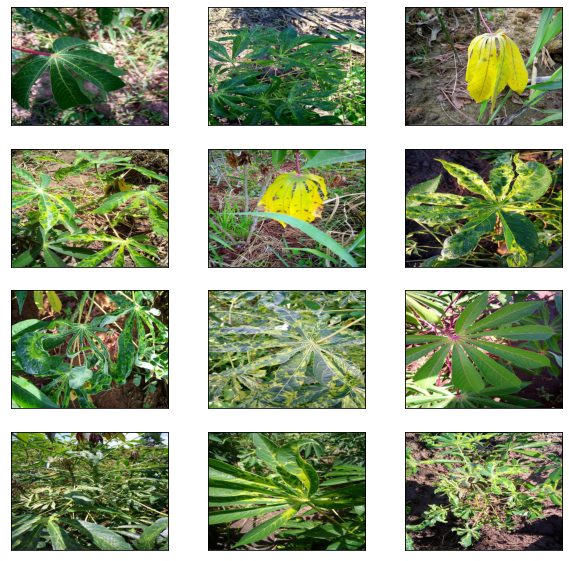

In [ ]:
plt.figure(figsize =(10,10),num=0)
for i,filename in enumerate(glob.iglob('/content/drive/My Drive/Colab Notebooks/train_images' + '**/*.jpg', recursive = True)):
    if i ==12:
        image = Image.open(filename)
        image_shape = np.array(image).shape
        print("The shape of the images is: {}".format(image_shape))
        break
    elif i<12:
        img = mpimg.imread(filename) # reading the image from the jpg files into an array.
        plt.subplot(4,3,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(img)# displaying the data as an image
plt.show()        

In [ ]:
batch_size = 32
# img_height = image_shape[0]
# img_width = image_shape[1]
img_height = int(image_shape[0]/3)
img_width  = int(image_shape[1]/3)

## Data PreProcessing

In [ ]:
# Performing on the fly image augmentation
train_datagen = ImageDataGenerator(rescale=1./255.,shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True, validation_split=0.2)



We've applied feature scaling,image augmentation and then split the train set into 2 partitions one for training and the other for validation just by specifying the argument validation_split=0.2 which splits the dataset into to 2 sets where the validation set will have 20% of the total images.

In [ ]:
train_generator = train_datagen.flow_from_dataframe(
dataframe = train_names,
directory = '/content/drive/My Drive/Colab Notebooks/train_images',
x_col = "image_id",
y_col = "label",
subset = "training",
batch_size = batch_size,
seed = 42,
shuffle = True,
class_mode = "sparse",
target_size = (img_height, img_width))

Found 17118 validated image filenames belonging to 5 classes.


In [ ]:
valid_generator = train_datagen.flow_from_dataframe(
dataframe = train_names,
directory = '/content/drive/My Drive/Colab Notebooks/train_images',
x_col = "image_id",
y_col = "label",
subset = "validation",
batch_size = batch_size,
seed =42,
shuffle = True,
class_mode ="sparse",
target_size = (img_height, img_width)
)

Found 4279 validated image filenames belonging to 5 classes.


## Iterating Over Data and Plotting it

## Now the data and labels are together!

In [ ]:
image_batch, labels_batch = next(iter(train_generator)) # getting a single batch from train generator
print(image_batch.shape)
print(labels_batch.shape)
print(labels_batch)

(32, 200, 266, 3)
(32,)
[3. 3. 3. 4. 4. 3. 4. 3. 2. 3. 4. 2. 3. 0. 1. 3. 2. 3. 3. 3. 3. 2. 3. 0.
 3. 4. 3. 3. 4. 3. 3. 3.]


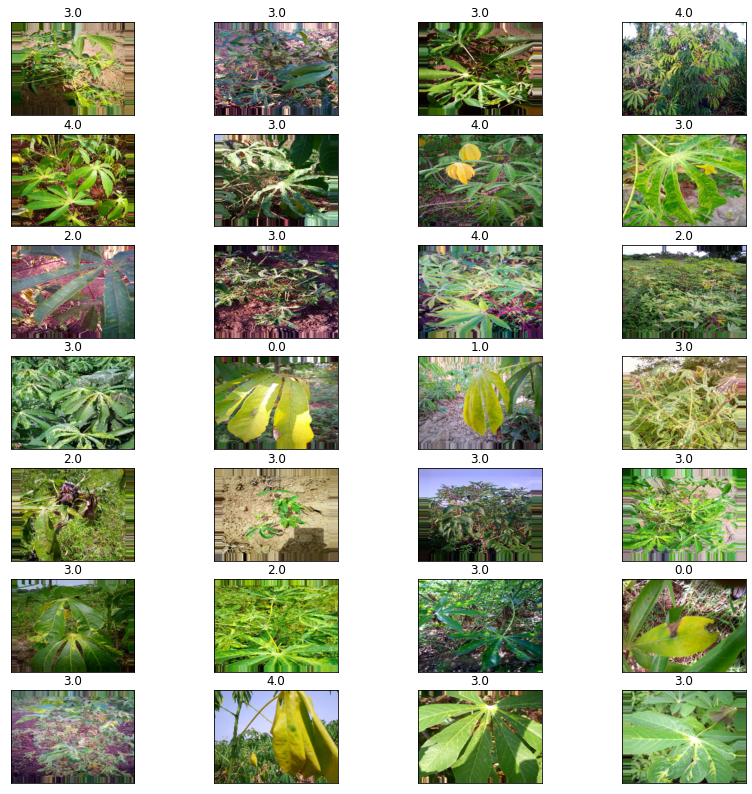

In [ ]:
plt.figure(figsize =(14,14),num=1)
for i in range(28):
    max_index =labels_batch[i]
    plt.subplot(7,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(image_batch[i])
    plt.title(max_index)
plt.show()    

In [ ]:
image_batch, labels_batch = next(iter(valid_generator))
print(image_batch.shape)
print(labels_batch.shape)
print(labels_batch)

(32, 200, 266, 3)
(32,)
[3. 3. 3. 2. 3. 2. 3. 3. 2. 3. 3. 3. 1. 3. 3. 3. 1. 3. 3. 2. 3. 3. 2. 1.
 3. 3. 3. 2. 4. 3. 2. 2.]


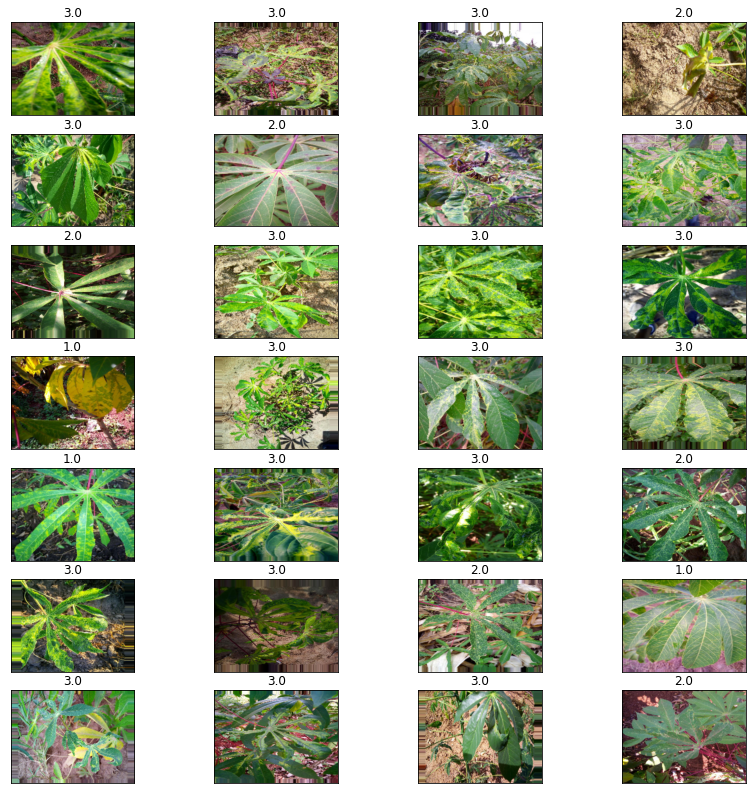

In [ ]:
plt.figure(figsize = (14,14),num=1)
for i in range(28):
    max_index = labels_batch[i]
    plt.subplot(7,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(image_batch[i])
    plt.title(max_index)
plt.show()    

## Building the Model

In [ ]:
# Initializing the CNN
cnn = tf.keras.models.Sequential()

In [ ]:
# Step1: Convolution
cnn.add(tf.keras.layers.Conv2D(filters = 64, kernel_size=11, activation ='relu', input_shape =(img_height, img_width,3)))


In [ ]:
# Step2: Pooling
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides = 2))

In [ ]:
# Adding a second Convolution layer
cnn.add(tf.keras.layers.Conv2D(filters = 32, kernel_size=5, activation ='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides = 2))

In [ ]:
# Adding a third Convolution layer
cnn.add(tf.keras.layers.Conv2D(filters = 32, kernel_size=3, activation ='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides = 2))

In [ ]:
# Adding a fourth Convolution layer
# cnn.add(tf.keras.layers.Conv2D(filters = 32, kernel_size=3, activation ='relu'))
# cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides = 2))

In [ ]:
# Step3: Flattening
cnn.add(tf.keras.layers.Flatten())

In [ ]:
# Step4: Full Connection
cnn.add(tf.keras.layers.Dense(units = 512, activation = 'relu'))

In [ ]:
# Adding another fully connected layer
cnn.add(tf.keras.layers.Dense(units = 128, activation = 'relu'))

In [ ]:
# Adding another fully connected layer
# cnn.add(tf.keras.layers.Dense(units = 128, activation = 'relu'))

In [ ]:
# Step5: Output Layer
cnn.add(tf.keras.layers.Dense(units=5, activation ='softmax'))

## Training the CNN

In [ ]:
# compiling the CNN
cnn.compile(optimizer = 'adam',loss ='sparse_categorical_crossentropy', metrics=["accuracy"])

In [ ]:
# Training the CNN on the Training set and evaluating it on the Test set
history = cnn.fit(x = train_generator, validation_data = valid_generator, epochs =15)

Epoch 1/15
535/535 [==============================] - 1908s 4s/step - loss: 1.1548 - accuracy: 0.6137 - val_loss: 1.1407 - val_accuracy: 0.6181
Epoch 2/15
535/535 [==============================] - 1122s 2s/step - loss: 1.0396 - accuracy: 0.6276 - val_loss: 1.0081 - val_accuracy: 0.6308
Epoch 3/15
535/535 [==============================] - 1089s 2s/step - loss: 0.9956 - accuracy: 0.6405 - val_loss: 0.9718 - val_accuracy: 0.6375
Epoch 4/15
535/535 [==============================] - 1087s 2s/step - loss: 0.9722 - accuracy: 0.6493 - val_loss: 0.9609 - val_accuracy: 0.6443
Epoch 5/15
535/535 [==============================] - 1086s 2s/step - loss: 0.9427 - accuracy: 0.6539 - val_loss: 0.9392 - val_accuracy: 0.6513
Epoch 6/15
535/535 [==============================] - 1089s 2s/step - loss: 0.9167 - accuracy: 0.6623 - val_loss: 0.9444 - val_accuracy: 0.6525
Epoch 7/15
535/535 [==============================] - 1089s 2s/step - loss: 0.8969 - accuracy: 0.6687 - val_loss: 0.9647 - val_accuracy:

Unfortunately, the capacity of our model is clearly too low to learn the complexities of the data set. Not only the training loss and training accuracy is starting to stagnate very early in the training process, but the validation loss and validation accuracy are extremely volatile which is a symptom of underfitting.

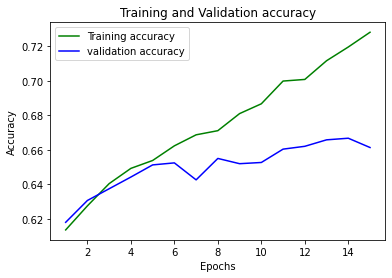

In [ ]:
# Evaluating the model 
loss_train = history.history['accuracy']
loss_val = history.history['val_accuracy']
epochs = range(1,16)
plt.plot(epochs, loss_train, 'g', label='Training accuracy')
plt.plot(epochs,loss_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Making a single Prediction

In [ ]:
from keras.preprocessing import image
test_image = image.load_img('/content/drive/My Drive/Colab Notebooks/test_images/2216849948.jpg', target_size = (img_height, img_width))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = cnn.predict(test_image)
train_generator.class_indices
if result[0][0] == 0:
    prediction = 'Cassava Bacterial Blight (CBB)'
elif result[0][0] == 1:
    prediction = 'Cassava Brown Streak Disease (CBSD)'   
elif result[0][0] == 2:
    prediction = 'Cassava Green Mottle (CGM)' 
elif result[0][0] == 3:
    prediction = 'Cassava Mosaic Disease (CMD)' 
elif result[0][0] == 4:
    prediction = 'Healthy'     
    

In [ ]:
print(prediction)

Cassava Bacterial Blight (CBB)
